In [35]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split

In [2]:
ins_data = pd.read_pickle('../../data/feature engineered/insurance.pkl')
ins_data

,age,sex,bmi,children,smoker,region,charges
0,-0.854167,-1.0,-0.304319,-0.5,-0.590433,0.000000,0.475094
1,-1.020833,0.0,0.389592,0.0,0.000000,1.000000,-1.302772
2,-0.447917,0.0,0.302496,1.0,0.000000,1.000000,-0.585858
3,-0.239583,0.0,-0.987437,-0.5,0.000000,0.000000,0.692467
4,-0.281250,0.0,-0.183343,-0.5,0.000000,0.000000,-0.693955
...,...,...,...,...,...,...,...
1333,0.468750,0.0,0.067477,1.0,0.000000,0.000000,0.097725
1334,-1.020833,-1.0,0.178465,-0.5,0.000000,-0.025641,-1.119708
1335,-1.020833,-1.0,0.727647,-0.5,0.000000,1.000000,-1.345025
1336,-0.739583,-1.0,-0.571484,-0.5,0.000000,0.000000,-1.190043


In [3]:
Y = ins_data.loc[:, 'charges']
X = ins_data.drop('charges', axis=1)

In [4]:
X.shape, Y.shape

((1338, 6), (1338,))

In [5]:
freg_selection = SelectKBest(score_func=f_regression, k=4)
freg_selection.fit(X, Y)
df = freg_selection.transform(X)
df = pd.DataFrame(df, columns=['age', 'bmi', 'children', 'smoker'])
df

,age,bmi,children,smoker
0,-0.854167,-0.304319,-0.5,-0.590433
1,-1.020833,0.389592,0.0,0.000000
2,-0.447917,0.302496,1.0,0.000000
3,-0.239583,-0.987437,-0.5,0.000000
4,-0.281250,-0.183343,-0.5,0.000000
...,...,...,...,...
1333,0.468750,0.067477,1.0,0.000000
1334,-1.020833,0.178465,-0.5,0.000000
1335,-1.020833,0.727647,-0.5,0.000000
1336,-0.739583,-0.571484,-0.5,0.000000


In [36]:
x_train, x_test, y_train, y_test = train_test_split(df, Y, train_size=0.8, random_state=64)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1070, 4), (268, 4), (1070,), (268,))

****Ensemble Models****

In [6]:
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

In [7]:
cv = RepeatedKFold(n_splits=3, n_repeats=6, random_state=1)

***Bagging***

Bagging essentially helps reduce the variance of the entire ensemble by introducing
randomization into its construction procedure and is usually used with a base predictor
that has a tendency to overfit the training data. The primary point of consideration
here would be the stability (or lack thereof) of the training dataset: Bagging can
improve accuracy in cases where a slight perturbation in the data could result in a
significant change in the trained model.

In [8]:
bagging_grid = dict()
bagging_grid['base_estimator'] = [LinearRegression(),
                                  Ridge(alpha=0.1),
                                  KNeighborsRegressor(algorithm='kd_tree', n_neighbors=9),
                                  DecisionTreeRegressor(max_depth=5, min_samples_split=30)]
bagging_grid['max_samples'] = np.arange(0.1, 1.1, 0.1)
bagging_grid['max_features'] = np.arange(0.1, 1.1, 0.1)

In [9]:
bagging_model = BaggingRegressor()

bagging_grid_search = GridSearchCV(bagging_model, bagging_grid, cv=cv, scoring='r2')
bagging_scores = bagging_grid_search.fit(df, Y)

In [10]:
bagging_scores.best_score_, bagging_scores.best_estimator_

(0.8261960769033668,
 BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                       min_samples_split=30),
                  max_samples=0.6))

***Random Forest***

In [11]:
rf_grid = dict()
rf_grid['criterion'] = ['mse', 'mae']
rf_grid['max_depth'] = list(range(1, 13))
rf_grid['min_samples_split'] = [25, 30, 35, 40, 50]

In [12]:
rf_model = RandomForestRegressor()

rf_grid_search = GridSearchCV(rf_model, rf_grid, cv=cv, scoring='r2')
rf_scores = rf_grid_search.fit(df, Y)

In [13]:
rf_scores.best_score_, rf_scores.best_estimator_

(0.8278797499155672, RandomForestRegressor(max_depth=4, min_samples_split=25))

***adaptive boosting***

In [28]:
adaboost_grid = dict()
adaboost_grid['base_estimator'] = [LinearRegression(),
                                   Ridge(alpha=0.1),
                                   KNeighborsRegressor(algorithm='kd_tree', n_neighbors=9),
                                   DecisionTreeRegressor(max_depth=5, min_samples_split=30)]
adaboost_grid['learning_rate'] = np.log(list(range(2, 101, 8)))
adaboost_grid['loss'] = ['linear', 'square', 'exponential']

In [29]:
adaboost_model = AdaBoostRegressor()

adaboost_grid_search = GridSearchCV(adaboost_model, adaboost_grid, cv=cv, scoring='r2')
adaboost_scores = adaboost_grid_search.fit(df, Y)

In [30]:
adaboost_scores.best_score_, adaboost_scores.best_estimator_

(0.7639922591311055,
 AdaBoostRegressor(base_estimator=Ridge(alpha=0.1),
                   learning_rate=2.8903717578961645))

***stacking***

In [31]:
stacking = StackingRegressor(estimators=[('ols', LinearRegression()),
                                         ('ridge', Ridge(alpha=0.1)),
                                         ('knn', KNeighborsRegressor(algorithm='kd_tree', n_neighbors=9)),
                                         ('tree', DecisionTreeRegressor(max_depth=5, min_samples_split=30))],
                             final_estimator=RandomForestRegressor(max_depth=4, min_samples_split=25))

In [32]:
stacking_scores = cross_val_score(stacking, df, Y, cv=cv, scoring='r2')

In [34]:
print(f'average score: {np.mean(stacking_scores) * 100}\n'
      f'standard deviation: {np.std(stacking_scores)}')

average score: 81.44999915225942
standard deviation: 0.026288499139540476


In [37]:
bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                                min_samples_split=30),
                           max_samples=0.6)
random_forest = RandomForestRegressor(max_depth=4, min_samples_split=25)
adaboost = AdaBoostRegressor(base_estimator=Ridge(alpha=0.1), learning_rate=2.8903717578961645)
stacking = StackingRegressor(estimators=[('ols', LinearRegression()),
                                         ('ridge', Ridge(alpha=0.1)),
                                         ('knn', KNeighborsRegressor(algorithm='kd_tree', n_neighbors=9)),
                                         ('tree', DecisionTreeRegressor(max_depth=5, min_samples_split=30))],
                             final_estimator=RandomForestRegressor(max_depth=4, min_samples_split=25))

bagging.fit(x_train, y_train)
random_forest.fit(x_train, y_train)
adaboost.fit(x_train, y_train)
stacking.fit(x_train, y_train)

StackingRegressor(estimators=[('ols', LinearRegression()),
                              ('ridge', Ridge(alpha=0.1)),
                              ('knn',
                               KNeighborsRegressor(algorithm='kd_tree',
                                                   n_neighbors=9)),
                              ('tree',
                               DecisionTreeRegressor(max_depth=5,
                                                     min_samples_split=30))],
                  final_estimator=RandomForestRegressor(max_depth=4,
                                                        min_samples_split=25))

In [38]:
bagging_pred = bagging.predict(x_test)
random_forest_pred = random_forest.predict(x_test)
adaboost_pred = adaboost.predict(x_test)
stacking_pred = stacking.predict(x_test)

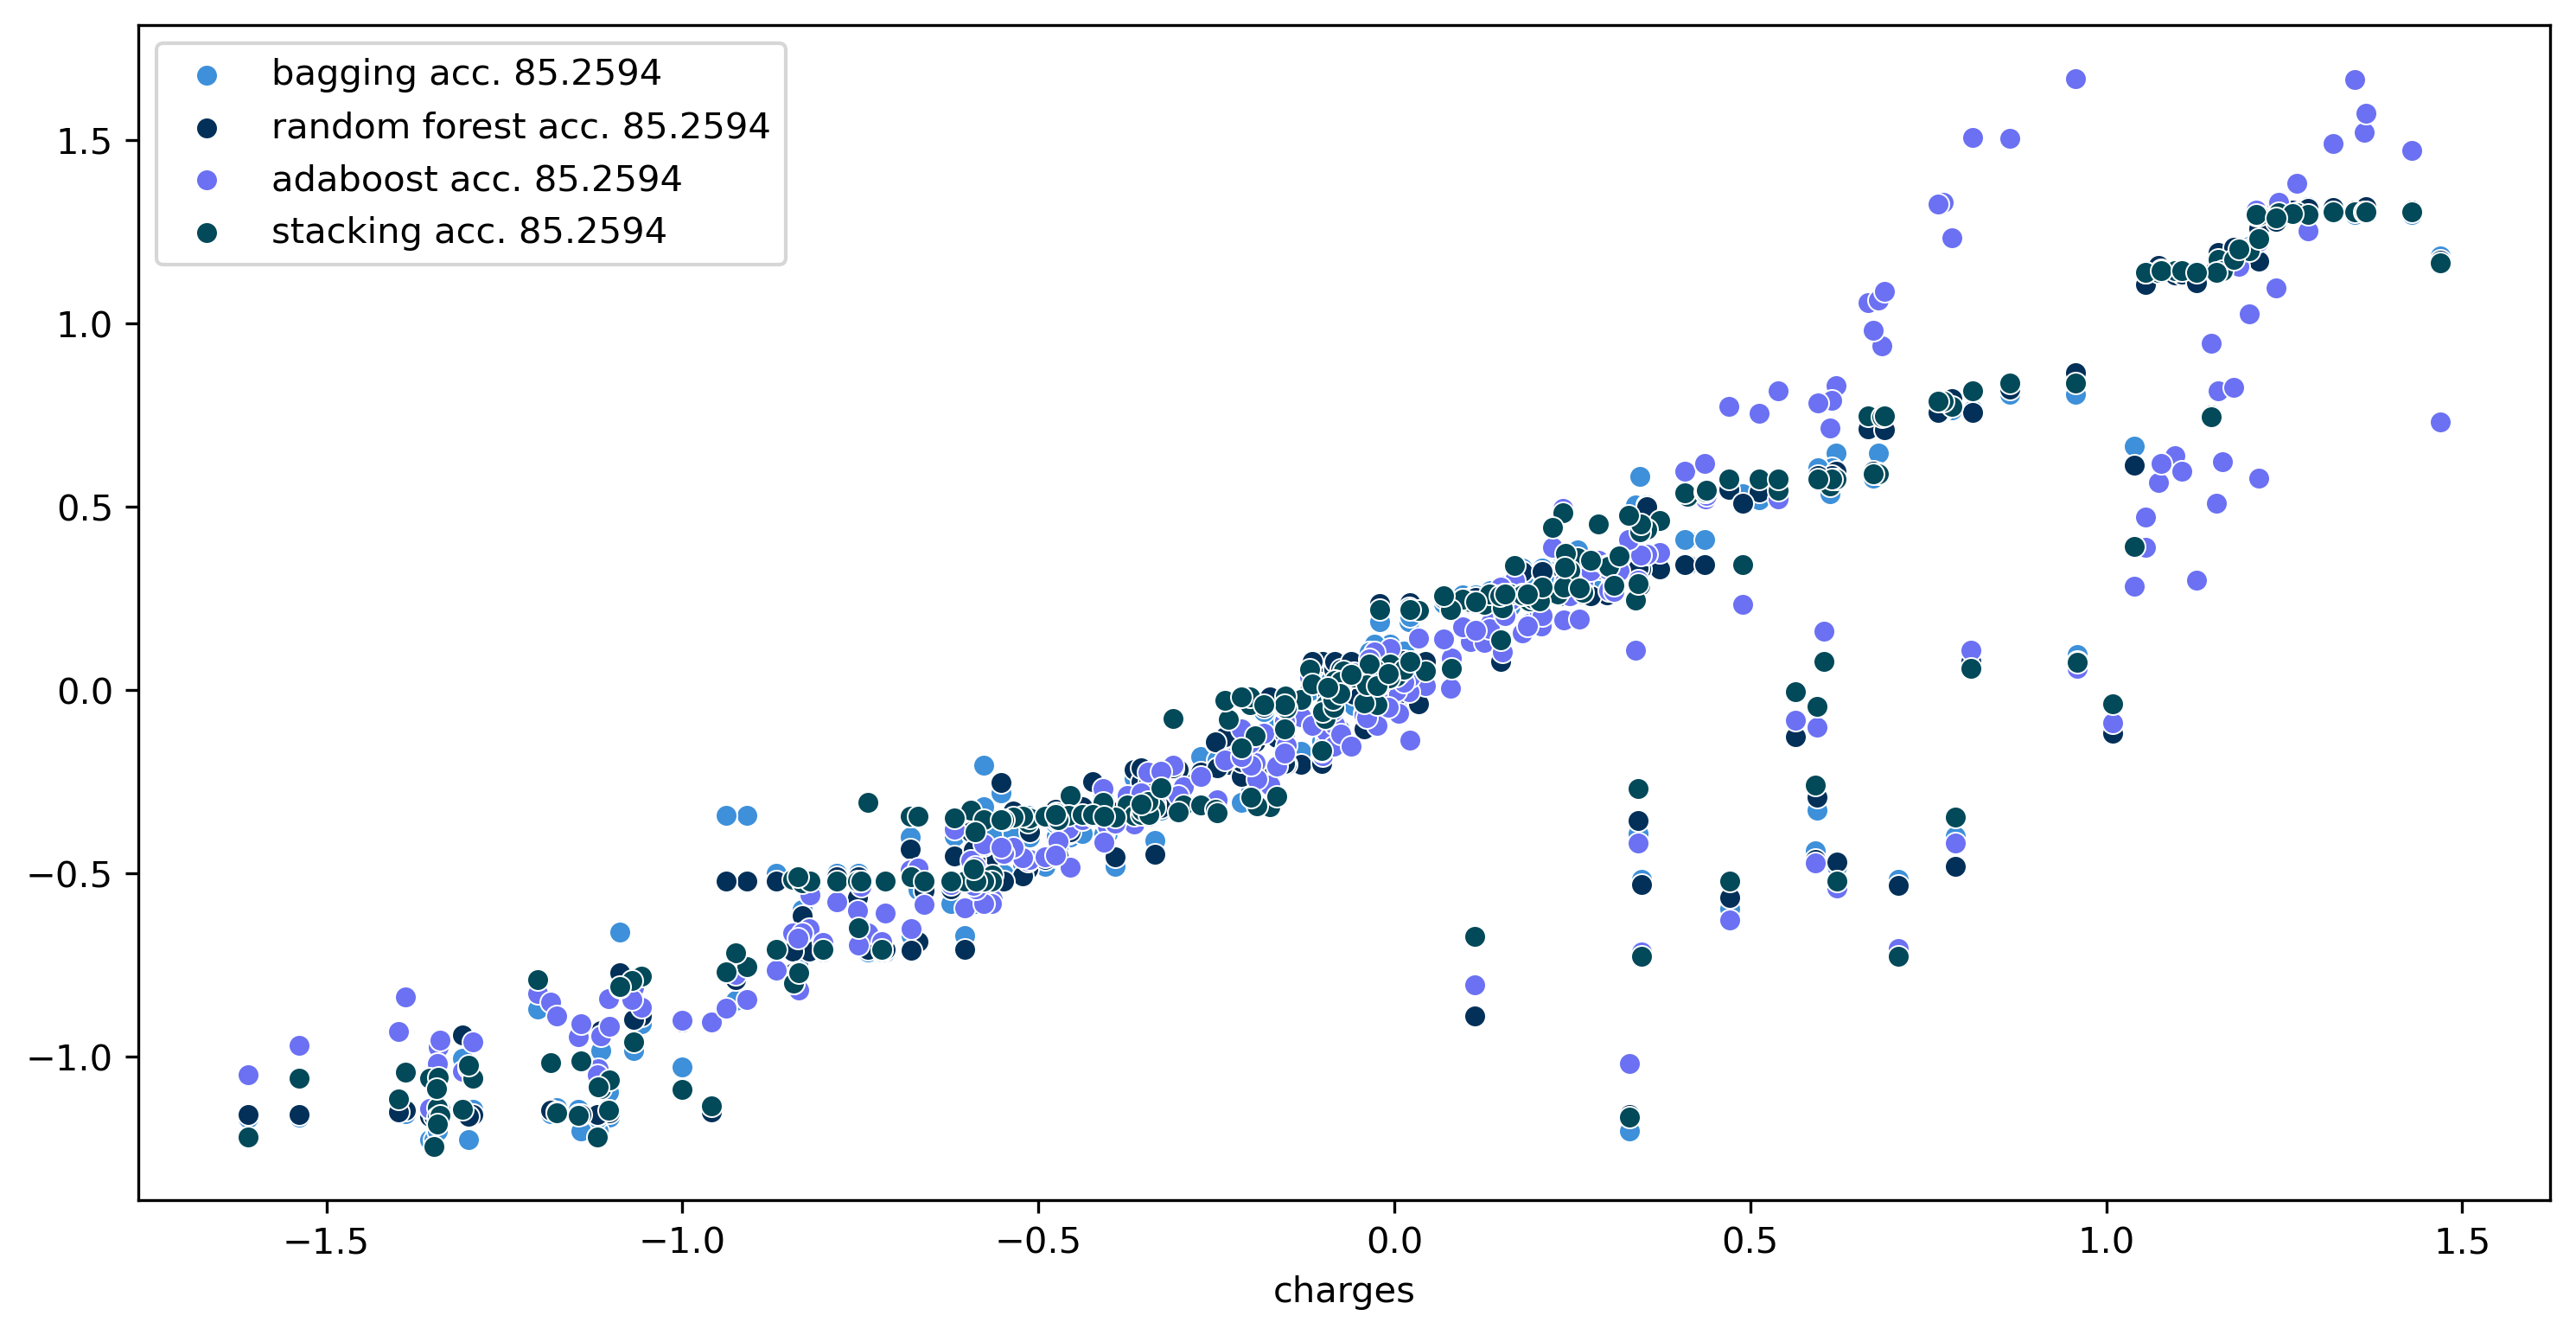

In [42]:
plt.figure(figsize=[12, 6], dpi=300)
sns.scatterplot(x=y_test, y=bagging_pred,
                color='#3D90D9',
                label=f'bagging acc. {np.round(bagging.score(x_test, y_test) * 100, 4)}')
sns.scatterplot(x=y_test, y=random_forest_pred,
                color='#023059',
                label=f'random forest acc. {np.round(bagging.score(x_test, y_test) * 100, 4)}')
sns.scatterplot(x=y_test, y=adaboost_pred,
                color='#6B71F2',
                label=f'adaboost acc. {np.round(bagging.score(x_test, y_test) * 100, 4)}')
sns.scatterplot(x=y_test, y=stacking_pred,
                color='#024959',
                label=f'stacking acc. {np.round(bagging.score(x_test, y_test) * 100, 4)}')
plt.legend()
plt.savefig('../../demo/Model Creation/ensemble models performance.png')
plt.show()

In [43]:
optimized_model_performance = [['bagging',
                                bagging.score(x_train, y_train),
                                bagging.score(x_test, y_test)],
                               ['random forest',
                                random_forest.score(x_train, y_train),
                                random_forest.score(x_test, y_test)],
                               ['adaboost',
                                adaboost.score(x_train, y_train),
                                adaboost.score(x_test, y_test)],
                               ['stacking',
                                stacking.score(x_train, y_train),
                                stacking.score(x_test, y_test)]]
optimized_model_performance = pd.DataFrame(optimized_model_performance,
                                           columns=['model', 'scores in train', 'scores in test'])
optimized_model_performance

,model,scores in train,scores in test
0,bagging,0.843557,0.852594
1,random forest,0.838272,0.854912
2,adaboost,0.759680,0.791620
3,stacking,0.831071,0.851779
